<a href="https://colab.research.google.com/github/shreyasat27/pennylane-27524/blob/main/Photonic_quantum_computers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Import some libraries for a nicer plot
from scipy.stats import gaussian_kde
from numpy import vstack as vstack

In [ ]:
#define the device
dev = qml.device("default.gaussian", wires=1, shots=1000)


In photonics devices, wire = qumodes (they are not two-level system in general, so we take infinity superposition of basis states to represent their quantum)

how the measured values of position and momentum are distributed in the x-p space (phase space)

The initial state in default.gaussian is the vacuum so the circuits to measure the quadratures need not contain any operations, except for measurements! We plot 1000 measurement results for both x and p.

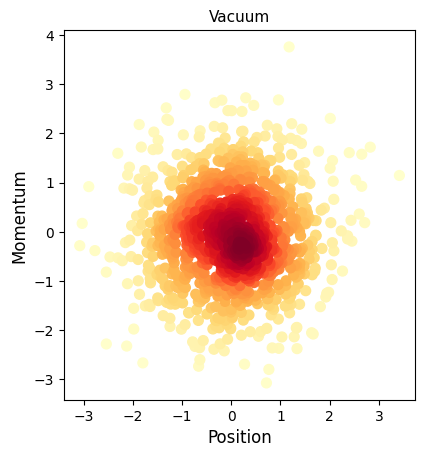

In [ ]:
@qml.qnode(dev)
def vacuum_measure_x():
  return qml.sample(qml.QuadX(0)) #sample X quadratures

@qml.qnode(dev)
def vacuum_measure_p():
  return qml.sample(qml.QuadP(0)) #sample p quadratures

#sample measurement in phase space

x_sample = vacuum_measure_x()
p_sample = vacuum_measure_p()

#point density calculation
xp = vstack([x_sample, p_sample])
z = gaussian_kde(xp)(xp)

#sort the points by density
sorted = z.argsort()
x,y,z = x_sample[sorted], p_sample[sorted], z[sorted]

#make the plot
fig, ax = plt.subplots()
ax.scatter(x,y,c = z, s= 50, cmap ="YlOrRd")
plt.title("Vacuum", fontsize =11)
ax.set_ylabel("Momentum", fontsize =12)
ax.set_xlabel('Position', fontsize =12)
ax.set_aspect("equal", adjustable = "box")
plt.show()



In [ ]:
dev_exact = qml.device("default.gaussian", wires=1)  # No explicit shots gives analytic calculations


@qml.qnode(dev_exact)
def vacuum_mean_x():
    return qml.expval(qml.QuadX(0))  # Returns exact expecation value of x


@qml.qnode(dev_exact)
def vacuum_mean_p():
    return qml.expval(qml.QuadP(0))  # Returns exact expectation value of p


@qml.qnode(dev_exact)
def vacuum_var_x():
    return qml.var(qml.QuadX(0))  # Returns exact variance of x


@qml.qnode(dev_exact)
def vacuum_var_p():
    return qml.var(qml.QuadP(0))  # Returns exact variance of p


# Print calculated statistical quantities
print("Expectation value of x-quadrature: {}".format(vacuum_mean_x()))
print("Expectation value of p-quadrature: {}".format(vacuum_mean_p()))
print("Variance of x-quadrature: {}".format(vacuum_var_x()))
print("Variance of p-quadrature: {}".format(vacuum_var_p()))



Expectation value of x-quadrature: 0.0
Expectation value of p-quadrature: 0.0
Variance of x-quadrature: 1.0
Variance of p-quadrature: 1.0


What other Gaussian states are there? The states produced by lasers are called coherent states, which are also Gaussian with  
Δx=Δp=1.
  
Coherent states, in general, can have non-zero expectation values for the quadratures (i.e., they are not centered around the origin).

The default.gaussian device allows for the easy preparation of coherent states through the function

A photonic system is said to be in a Gaussian state if its Wigner function is a two-dimensional Gaussian function

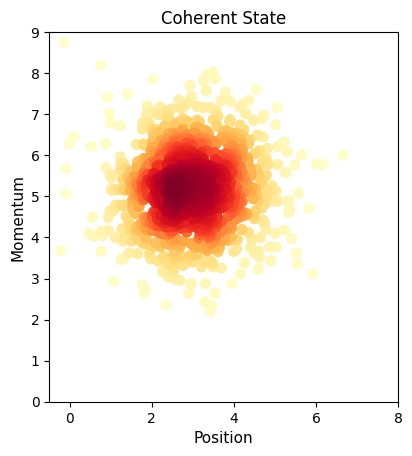

In [ ]:
@qml.qnode(dev)
def measure_coherent_x(alpha, phi):
    qml.CoherentState(alpha, phi, wires=0) #it prepares coherent states
    return qml.sample(qml.QuadX(0)) #measure X quadrature

@qml.qnode(dev)
def measure_coherent_p(alpha, phi):
    qml.CoherentState(alpha, phi, wires=0) #prepares coherent states
    return qml.sample(qml.QuadP(0)) #measure P quadrature

#choosing alpha and phi samples for 1000 measurements

x_sample_coherent = measure_coherent_x(3,np.pi/3)
p_sample_coherent = measure_coherent_p(3, np.pi/3)

# Plot as before
xp = vstack([x_sample_coherent, p_sample_coherent])
z1 = gaussian_kde(xp)(xp)

sorted = z1.argsort()
x,y,z = x_sample_coherent[sorted], p_sample_coherent[sorted], z1[sorted]

fig, ax1 = plt.subplots()
ax1.scatter(x,y,c = z, s=50, cmap ="YlOrRd")
ax1.set_title("Coherent State", fontsize=12)
ax1.set_ylabel("Momentum", fontsize=11)
ax1.set_xlabel("Position", fontsize=11)
ax1.set_aspect("equal", adjustable ='box')
plt.xlim([-0.5,8])
plt.ylim([0,9])
plt.show()

Gaussian operations:

We have only learned about two types of Gaussian states so far. The vacuum can be obtained by carefully isolating a system from any environmental influences, and a coherent state can be produced by a laser, so we already have these at hand. But how can we obtain any Gaussian state of our liking? This is achieved through Gaussian operations, which transform a Gaussian state to another Gaussian state. These operations are relatively easy to implement in a lab using some of the optical elements introduced in the table below.

We have 1. Waveguide 2. Phase shifter 3. Beamsplitter

The vacuum is centered at the origin in phase space. It is advantageous to generate states that are centered at any point in phase space. How would we, for example, change the mean x of the x-quadrature without changing anything else about the state? This can be done via the displacement operator, implemented in PennyLane via Displacement. Let's see the effect of this operation on an intial coherent state.



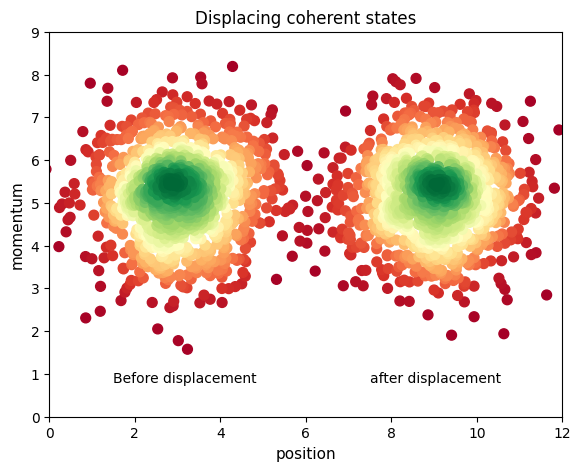

In [ ]:
@qml.qnode(dev)
def displace_coherent_x(alpha, phi, x):
    qml.CoherentState(alpha, phi, wires =0) #create cohent state
    qml.Displacement(x,0,wires=0) #second argument is displacement direction in phase space
    return qml.sample(qml.QuadX(0))

@qml.qnode(dev)
def displace_coherent_p(alpha,phi, x):
    qml.CoherentState(alpha, phi, wires=0)
    qml.Displacement(x,0,wires=0)
    return qml.sample(qml.QuadP(0))

#we plot both the initial and displaced state
initial_x = displace_coherent_x(3, np.pi/3,0) #initial state amounts to 0 displacement
initial_p = displace_coherent_p(3, np.pi/3,0)
displaced_x = displace_coherent_x(3,np.pi/3,3) #displace x=3 in x-direction
displaced_p = displace_coherent_p(3, np.pi/3,3)

#plot as before
fig, ax1 = plt.subplots(figsize =(10,5))
xp1 = vstack([initial_x, initial_p])
z1 = gaussian_kde(xp1)(xp1)
sorted1 = z1.argsort()
x1,y1,z1 = initial_x[sorted1], initial_p[sorted1], z1[sorted1]

xp2 = vstack([displaced_x, displaced_p])
z2 = gaussian_kde(xp2)(xp2)
sorted2 = z2.argsort()
x2,y2,z2 = displaced_x[sorted2], displaced_p[sorted2], z2[sorted2]

ax1.scatter(x1,y1,c = z1, s=50, cmap ="RdYlGn")
ax1.scatter(x2,y2,c = z2, s=50, cmap ="RdYlGn")

plt.xlim([0,12])
plt.ylim([0,9])

ax1.set_aspect("equal", adjustable ="box")
plt.text(1.5,0.8,"Before displacement")
plt.text(7.5,0.8,"after displacement")

ax1.set_ylabel("momentum", fontsize=11)
ax1.set_xlabel("position", fontsize=11)

ax1.set_title("Displacing coherent states", fontsize=12)
ax1.set_aspect("equal", adjustable ="box")
plt.show()


So how do we make a displacement operation in the lab? One method is shown below, which uses a beamsplitter and a source of high-intensity coherent light.

We can check that this setup implements a displacement operator using PennyLane. This time, we need two qumodes, since we rely on combining the input state that we want to displace with a coherent state in a beamsplitter. Let us code this circuit in the case that the input is a coherent state as a particular case (the operation will work for any state). Let us be mindful that this will only work when the amplitude of the input state is much smaller than that of the auxiliary coherent state.

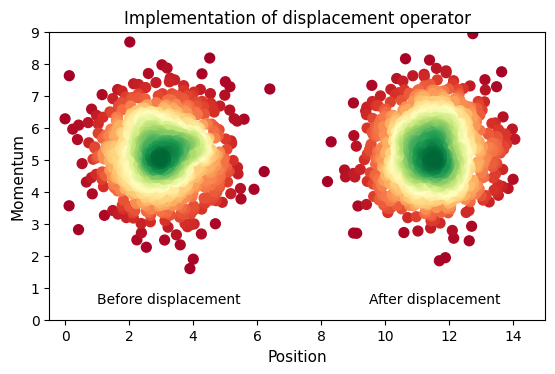

In [ ]:
dev2 =qml.device("default.gaussian", wires =2, shots =1000)

@qml.qnode(dev2)
def disp_optics(z,x):
  qml.CoherentState(z, 0, wires=0)
  qml.CoherentState(3, np.pi/3, wires=1)
  qml.Beamsplitter(np.arccos(1-x**2/z**2),0,wires=[0,1])
  return qml.sample(qml.QuadX(1))

@qml.qnode(dev2)
def mom_optics(z,x):
  qml.CoherentState(z,0,wires=0)
  qml.CoherentState(3, np.pi/3, wires=1)
  qml.Beamsplitter(np.arccos(1-x**2/z**2), 0, wires=[0,1])
  return qml.sample(qml.QuadP(1))

# Plot quadrature measurement before and after implementation of displacement
initial_x = disp_optics(100, 0)  # Initial corresponds to beamsplitter with t=0 (x=0)
initial_p = mom_optics(100, 0)  # Amplitude of coherent state must be large
displaced_x = disp_optics(100, 3)
displaced_p = mom_optics(100, 3)  # Set some non-trivial t

# Plot as before
fig, ax1 = plt.subplots()

xp1 = vstack([initial_x, initial_p])
z1 = gaussian_kde(xp1)(xp1)
sorted1 = z1.argsort()
x1, y1, z1 = initial_x[sorted1], initial_p[sorted1], z1[sorted1]

xp2 = vstack([displaced_x, displaced_p])
z2 = gaussian_kde(xp2)(xp2)
sorted2 = z2.argsort()
x2, y2, z2 = displaced_x[sorted2], displaced_p[sorted2], z2[sorted2]

ax1.scatter(x1, y1, c = z1, s = 50, cmap = "RdYlGn")
ax1.scatter(x2, y2, c = z2, s = 50, cmap = "RdYlGn")
ax1.set_title("Initial", fontsize = 12)

plt.xlim([-0.5, 15])
plt.ylim([0, 9])

ax1.set_ylabel("Momentum", fontsize = 11)
ax1.set_xlabel("Position", fontsize = 11)

plt.text(1, 0.5, "Before displacement")
plt.text(9.5, 0.5, "After displacement")

ax1.set_aspect("equal", adjustable="box")

ax1.set_title("Implementation of displacement operator", fontsize = 12)

plt.show()

We see that we get a displaced state. The amount of displacement can be adjusted by changing the parameters of the beamsplitter. Similarly, we can implement rotations in phase space using Rotation, which simply amounts to changing the phase of light using a phase shifter.

if we also want to change the spread of the quadratures then, In PennyLane, we can generate squeezed states through the squeezing operator Squeezing, this function depends on r, phi

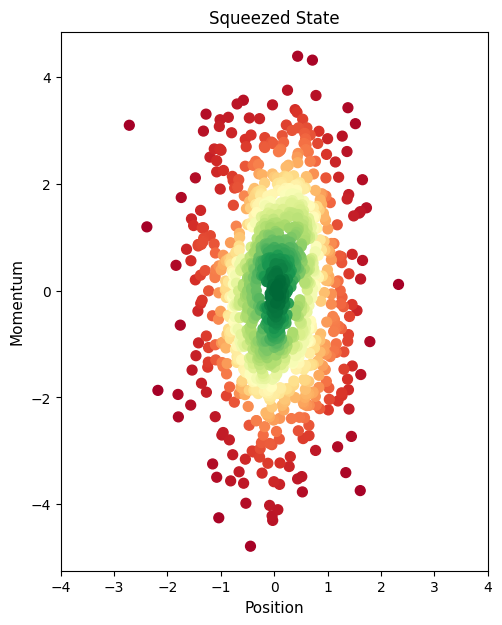

In [ ]:
@qml.qnode(dev)
def measure_squeezed_x(r):
    qml.Squeezing(r, 0, wires = 0)
    return qml.sample(qml.QuadX(0))


@qml.qnode(dev)
def measure_squeezed_p(r):
    qml.Squeezing(r, 0, wires = 0)
    return qml.sample(qml.QuadP(0))


# Choose alpha and phi and sample 1000 measurements
x_sample_squeezed = measure_squeezed_x(0.4)
p_sample_squeezed = measure_squeezed_p(0.4)

# Plot as before
xp = vstack([x_sample_squeezed, p_sample_squeezed])
z = gaussian_kde(xp)(xp)

sorted_meas = z.argsort()
x, y, z = x_sample_squeezed[sorted_meas], p_sample_squeezed[sorted_meas], z[sorted_meas]

fig, ax1 = plt.subplots(figsize=(7, 7))
ax1.scatter(x, y, c = z, s = 50, cmap = "RdYlGn")
ax1.set_title("Squeezed State", fontsize = 12)
ax1.set_ylabel("Momentum", fontsize = 11)
ax1.set_xlabel("Position", fontsize = 11)
ax1.set_xlim([-4, 4])
ax1.set_aspect("equal", adjustable = "box")
plt.show()

**Measuring quadratures**

measuring the current amounts to measuring the number of photons indirectly!

Except for the vacuum |0⟩,Fock states are not Gaussian. But all states of light are superpositions of Fock States, including Gaussian states!

In [ ]:
dev3= qml.device("default.gaussian", wires=1)

@qml.qnode(dev3)
def measure_n_coherent(alpha, phi):
  qml.Squeezing(alpha, phi, wires=0)
  return qml.expval(qml.NumberOperator(0))


coherent_expval = measure_n_coherent(1, np.pi/3)
print("Expected number of photos: {}".format(coherent_expval))

Expected number of photos: 1.3810978455418157


In [ ]:
dev_exact2 = qml.device("default.gaussian", wires = 2)


@qml.qnode(dev_exact2)
def measurement(a, phi):
    qml.Displacement(a, phi, wires = 0)  # Implement displacement using PennyLane
    return qml.expval(qml.QuadX(0))

@qml.qnode(dev_exact2)
def measurement2_0(a, theta, alpha, phi):
    qml.Displacement(a, theta, wires = 0)  # We choose the initial to be a displaced vacuum
    qml.CoherentState(alpha, phi, wires = 1)  # Prepare coherent as second qumode
    qml.Beamsplitter(np.pi / 4, 0, wires=[0, 1])  # Interfere both states
    return qml.expval(qml.NumberOperator(0))  # Read out N

@qml.qnode(dev_exact2)
def measurement2_1(a, theta, alpha, phi):
    qml.Displacement(a, theta, wires = 0)  # We choose the initial to be a displaced vacuum
    qml.CoherentState(alpha, phi, wires = 1)  # Prepare coherent as second qumode
    qml.Beamsplitter(np.pi / 4, 0, wires=[0, 1])  # Interfere both states
    return qml.expval(qml.NumberOperator(1))  # Read out N


print(
    "Expectation value of x-quadrature after displacement: {}\n".format(measurement(3, 0))
)
print("Expected current in each detector:")
print("Detector 1: {}".format(measurement2_0(3, 0, 1, 0)))
print("Detector 2: {}".format(measurement2_1(3, 0, 1, 0)))
print(
    "Difference between currents: {}".format(
        measurement2_1(3, 0, 1, 0) - measurement2_0(3, 0, 1, 0)
    )
)

Expectation value of x-quadrature after displacement: 6.0

Expected current in each detector:
Detector 1: 2.000000000000001
Detector 2: 7.999999999999998
Difference between currents: 5.999999999999997


To build a universal photonic quantum computer we need both Gaussian and non-Gaussian states. Moreover, we need to be able to entangle any two states.

Entanglement is not a problem, since combinations of Gaussian operations involving squeezers and beamsplitters can easily create entangled states! Let us set on the more challenging mission to find a way to prepare non-Gaussian states. All of the operations that we have learned so far—displacements, rotations, squeezing—are Gaussian. Do we need some kind of strange material that will implement a non-Gaussian operation? That’s certainly a possibility, and there are materials which can provide non-Gaussian interactions—like the Kerr effect. But relying on these non-linear materials is far from optimal, since the Kerr effect is weak and we don’t have much freedom to manipulate the setup into getting an arbitrary non-Gaussian state.

The measurement of the number of photons takes a Gaussian state and collapses it into a Fock state (although this destroys the photons); therefore, photon-number detection is not a Gaussian operation. Measuring the exact number of photons is not that easy. We need fancy devices known a photon-number resolving detectors (commonly abbreviated as PNRs), which are superconductor-based, so they work only at low temperatures. Combined with squeezed states and beamsplitters, we have all the ingredients to produce non-Gaussian states.

The main idea is to tweak a particular photonic circuit known as a Gaussian Boson Sampler

Gaussian boson sampling (GBS) is interesting on its own (see this tutorial for an in-depth discussion). So far, two quantum devices have used large-scale versions of this circuit to achieve quantum advantage on a particular computation, which involves sampling from a probability distribution that classical computers take too long to simulate. In 2019, USTC’s Jiuzhang device took 200 seconds to perform this sampling, which would take 2.5 billion years for some of our most powerful supercomputers. In 2022, Xanadu's Borealis performed the same calculation in 36 microseconds, with the added benefit of being programmable and available on the Cloud.

read more from: https://pennylane.ai/qml/demos/tutorial_photonics/#beyond-gaussian-states